# Tutorial
---
Notebook contains explict constructions of circuits and functions for minimazation that are consider in article: *G. Czelusta, J. Mielczarek, **Quantum circuits for the Ising spin networks***

We use **Penny Lane** Python library.

All names used in this notebook are the same as in the  article and all references are refrences to the article.

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Closed networks from single links

First we construct quantum circuit representing operator $W$:

In [3]:
def W(wires):
    qml.PauliX(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.PauliX(wires=wires[1])
    qml.CRY(2*np.arccos(1/np.sqrt(3)), wires=[wires[1],wires[0]])
    qml.PauliX(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[0])
    qml.T(wires=wires[0])
    qml.adjoint(qml.T)(wires=wires[1])
    qml.CNOT(wires=[wires[1],wires[0]])
    qml.adjoint(qml.T)(wires=wires[0])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.T(wires=wires[0])
    qml.adjoint(qml.T)(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[2]])
    qml.CNOT(wires=[wires[1],wires[3]])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires=wires[2])
    qml.CNOT(wires=[wires[2],wires[3]])

then we construct quantum circuit wich construct state of single link, in the article we use singlet states, but you can choose arbitrary states
$$|\mathcal{B},\frac{1}{2}\rangle=\frac{1}{\sqrt{2}}\left(|01\rangle-|10\rangle\right)$$

In [4]:
def link(wires):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[1])
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])

## Dipole

Here we construct dipole state using four links:

$$|\Gamma_2,\mathcal{B},\frac{1}{2}\rangle=P_\Gamma\otimes_{l\in\Gamma_2}|\mathcal{B},\frac{1}{2}\rangle=\frac{1}{\sqrt{2}}\left(|\iota_0\iota_0\rangle+|\iota_1\iota_1\rangle\right)$$

we need 8 qubits

In [5]:
dev8 = qml.device('lightning.qubit', wires=8, shots=20000) # we use simulator 'lightning.qubit', you can choose for example 'default.qubit'
# dev8 = qml.device('lightning.qubit', wires=8) # you can also omit 'shots=' and then obtain results without statistical noise simulated

then we construct circuit Fig.9

In [6]:
# @qml.qnode(dev8) # you can omit 'diff_method=', or choose other, to use faster but non-comaptible with real quantum devices methods
@qml.qnode(dev8, diff_method="parameter-shift")
def cost_circ(initial_layer_weights, weights):
    link([0,4])
    link([1,5])
    link([2,6])
    link([3,7])

    qml.adjoint(W)([0,1,2,3])
    qml.adjoint(W)([4,5,6,7])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4])
        
    return qml.probs(wires=range(8))

Here we define function which post-selects measurements to obtain projected state

In [7]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'08b')
        if k[1:4]=='000' and k[5:8]=='000':
            c[k[0]+k[4]] = probs[i]
    return c['00']/np.sum(list(c.values()))

We define cost function, Eq. 21

In [8]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

We can check cost function on some random parameters.

Variable ```initial_layer_weights``` needs to have shape $(N)$, where $N$ is number of qubits in anstaz, in this case $N=2$.

Variable ```weights``` needs to have shape $(L,N-1,2)$, where $L$ is number of layers in ansatz, $N$ is number of qubits in anstaz, in this case $L=1$, $N=2$.

For more details, see Fig. 8 and documentation of ```SimplifiedTwoDesign```.

In [9]:
initial_layer_weights=np.random.rand(2)*2*np.pi
weights=np.random.rand(1,1,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.99839744, requires_grad=True)

Then we can optimize our ansatz. We choose classical optimizer, here ```AdamOptimizer```, maximal number of iteration in optimization loop, here $100$ and converge tolerance, here $10^{-6}$. We initialize parameters randomly. At the end we plot history of cost function during minimalization.

Iteration = 0,  Cost = 0.98661800
Iteration = 20,  Cost = 0.09498355


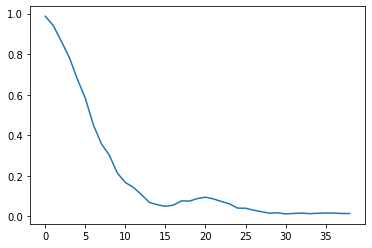

In [10]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 100
conv_tol = 1e-06

init_params = [np.random.rand(2)*2*np.pi, np.random.rand(1,1,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

We can now compute fidelity of obtained state. We execute ansatz with optimized parameters and check if it reproduces dipole state:

In [16]:
def fidelity_dipole(params):
    @qml.qnode(qml.device('lightning.qubit', wires=2))
    def dipole(optimized_params):
        qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=[0,1])
        return qml.state()

    dipole_exact = [1/np.sqrt(2),0,0,1/np.sqrt(2)]

    return np.abs(np.dot(dipole(params), dipole_exact))

In [14]:
dipole_params = params

In [17]:
fidelity_dipole(dipole_params)

0.9939487603661952

In similar way we can construct states for larger spin netorks. But construction starting from single links is not the most optimal one. Therefore, er show construction by gluing spin networks.

## Pentagram

Very similar steps lead to pentagram network. Now we need 10 links connected according to ```pentagram_links```, we need 5 operators $W^\dagger$ and 5-qubit ansatz.

In [8]:
dev20 = qml.device('default.qubit', wires=20)

In [9]:
pentagram_links = [[0,4],[1,8],[2,12],[3,16],[5,9],[6,13],[7,17],[10,14],[11,18],[15,19]]

In [10]:
@qml.qnode(dev20)
def cost_circ(initial_layer_weights, weights):
    for l in pentagram_links:
        link(l)

    for i in range(5):
        qml.adjoint(W)(range(4*i,4*(i+1)))

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,8,12,16])
        
    return qml.probs(wires=range(20))

In [11]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'020b')
        if k[1:4]=='000' and k[5:8]=='000' and k[9:12]=='000' and k[13:16]=='000' and k[17:20]=='000':
            c[k[0]+k[4]+k[8]+k[12]+k[16]] = probs[i]
    return c['00000']/np.sum(list(c.values()))

In [12]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [13]:
initial_layer_weights=np.random.rand(5)*2*np.pi
weights=np.random.rand(1,4,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.99987436, requires_grad=True)

Iteration = 0,  Cost = 0.99711557
Iteration = 20,  Cost = 0.37846557
Iteration = 40,  Cost = 0.29017491
Iteration = 60,  Cost = 0.08489050
Iteration = 80,  Cost = 0.03805956
Iteration = 100,  Cost = 0.02419218
Iteration = 120,  Cost = 0.00907390
Iteration = 140,  Cost = 0.00817245


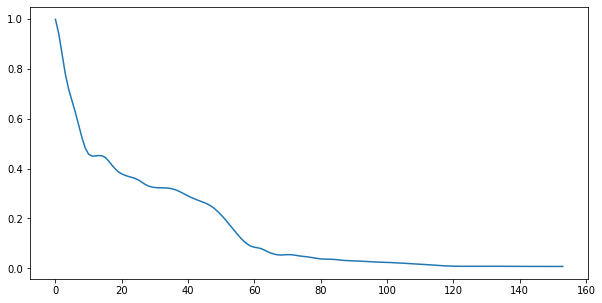

In [20]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 500
conv_tol = 1e-06

init_params = [np.random.rand(5)*2*np.pi, np.random.rand(3,4,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [26]:
costs[-1]

0.007953895910441933

In [21]:
dev5 = qml.device('default.qubit', wires=5)

In [22]:
@qml.qnode(dev5)
def pentagram(optimized_params):
    qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=range(5))
    return qml.state()

In [23]:
pentagram(params)

tensor([ 0.38173425+0.j, -0.00929067+0.j, -0.01804923+0.j,
         0.40936991+0.j,  0.03151203+0.j, -0.01042196+0.j,
         0.01519517+0.j,  0.00628369+0.j, -0.0051039 +0.j,
         0.00754334+0.j, -0.02596306+0.j,  0.00371136+0.j,
        -0.03806279+0.j, -0.22259474+0.j, -0.25553824+0.j,
         0.24194752+0.j, -0.00887507+0.j,  0.0043533 +0.j,
        -0.01164118+0.j, -0.01122513+0.j, -0.01085522+0.j,
        -0.24808501+0.j, -0.23454355+0.j, -0.26667178+0.j,
         0.3952221 +0.j,  0.01533096+0.j,  0.00772909+0.j,
        -0.15028288+0.j, -0.02391893+0.j, -0.26115278+0.j,
         0.27029672+0.j, -0.01560614+0.j], requires_grad=True)

In [24]:
pentagram_exact = 1/np.sqrt(14)*np.array([3/2,0,0,3/2,0,0,0,0,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,1,0,0,0,0,0,-np.sqrt(3)/2,-np.sqrt(3)/2,-1,3/2,0,0,-1/2,0,-1,1,0])

In [25]:
np.dot(pentagram(params), pentagram_exact)

(0.9960141042504967+0j)

# Gluing open networks

## Open pentagram, i.e. 4-node network with four open links

Similarly we prepare open pentagram by ommiting one of $W^\dagger$.

In [89]:
@qml.qnode(dev20)
def cost_circ(initial_layer_weights, weights):
    for l in pentagram_links:
        link(l)

    for i in range(4):
        qml.adjoint(W)(range(4*i,4*(i+1)))

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,8,12,16,17,18,19])
        
    return qml.probs(wires=range(20))

In [90]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'020b')
        if k[1:4]=='000' and k[5:8]=='000' and k[9:12]=='000' and k[13:16]=='000':
            c[k[0]+k[4]+k[8]+k[12]+k[16:]] = probs[i]
    return c['00000000']/np.sum(list(c.values()))

In [91]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [92]:
initial_layer_weights=np.random.rand(8)*2*np.pi
weights=np.random.rand(1,7,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.99248964, requires_grad=True)

In [94]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

max_iterations = 500
conv_tol = 1e-06

init_params = [np.random.rand(8)*2*np.pi, np.random.rand(1,7,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

Iteration = 0,  Cost = 0.99857045


KeyboardInterrupt: 

In [108]:
open_pentagram_params = params

In [109]:
dev8 = qml.device('default.qubit', wires=8)

In [110]:
def open_pentagram_circ(optimized_params, wires):
    qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=wires)

In [111]:
@qml.qnode(dev8)
def open_pentagram(optimized_params):
    open_pentagram_circ(optimized_params, wires=range(8))
    return qml.state()

In [112]:
open_pentagram(open_pentagram_params)

tensor([-3.97551495e-02+0.j, -7.54507870e-05+0.j, -2.80822707e-01+0.j,
         1.08035861e-01+0.j,  2.21577308e-01+0.j, -9.68065032e-02+0.j,
        -2.14621597e-01+0.j,  9.63316123e-02+0.j, -2.31570815e-02+0.j,
         1.33652034e-02+0.j,  8.18856818e-02+0.j, -3.34006929e-02+0.j,
         1.62665056e-01+0.j, -6.86620509e-02+0.j, -1.13518043e-01+0.j,
         5.34357171e-02+0.j,  4.09385353e-02+0.j, -3.21268178e-04+0.j,
         2.81878616e-01+0.j, -1.08385601e-01+0.j, -2.29172612e-01+0.j,
         1.00053288e-01+0.j,  2.20668121e-01+0.j, -9.91194600e-02+0.j,
         2.15961031e-02+0.j, -1.17793515e-02+0.j, -6.38278997e-02+0.j,
         2.62287245e-02+0.j, -1.49983940e-01+0.j,  6.34067699e-02+0.j,
         1.06453269e-01+0.j, -4.99704340e-02+0.j,  3.64833920e-02+0.j,
        -2.02058362e-03+0.j,  2.19456104e-01+0.j, -8.41315435e-02+0.j,
        -2.08578260e-01+0.j,  9.07523015e-02+0.j,  1.95166847e-01+0.j,
        -8.79865708e-02+0.j,  9.46401383e-03+0.j, -1.87446614e-03+0.j,
      

In [ ]:
# open_pentagram_exact = 

In [104]:
# np.dot(open_pentagram(open_pentagram_params), open_pentagram_exact)

## Gluing two open pentagrams into decagram network

To glue two open pentagrams we need to use ansatz for open pentagram with optimized parameters.

In [98]:
dev16 = qml.device('default.qubit', wires=16)

We construct circuit, Fig. 17

In [113]:
@qml.qnode(dev16)
def cost_circ(initial_layer_weights, weights):
    open_pentagram_circ(open_pentagram_params, wires=range(8))
    open_pentagram_circ(open_pentagram_params, wires=range(8,16))

    qml.adjoint(W)([4,5,12,13])
    qml.adjoint(W)([6,7,14,15])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,1,2,3,4,6,8,9,10,11])
        
    return qml.probs(wires=range(16))

In [114]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'016b')
        if (k[5]+k[12]+k[13])=='000' and (k[7]+k[14]+k[15])=='000':
            c[k[0:5]+k[6]+k[8]+k[9:12]] = probs[i]
    return c[10*'0']/np.sum(list(c.values()))

In [115]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [116]:
initial_layer_weights=np.random.rand(10)*2*np.pi
weights=np.random.rand(1,9,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.9999754, requires_grad=True)

Iteration = 0,  Cost = 0.99999970


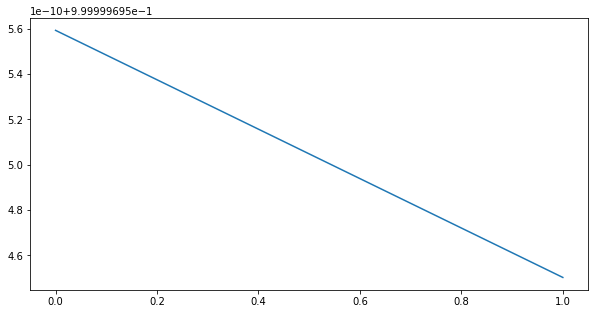

In [118]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

max_iterations = 500
conv_tol = 1e-06

init_params = [np.random.rand(10)*2*np.pi, np.random.rand(1,9,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

## Single node with free links

We construct circuit, Fig. 19, i.e. single node with free four links, it can be seen as open dipole.

In [9]:
@qml.qnode(dev8)
def cost_circ(initial_layer_weights, weights):
    link([0,4])
    link([1,5])
    link([2,6])
    link([3,7])

    qml.adjoint(W)([0,1,2,3])

    qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,5,6,7])
        
    return qml.probs(wires=range(8))

In [10]:
def proj_probs(probs):
    c = dict()
    for i in range(len(probs)):
        k=format(i,'08b')
        if k[1:4]=='000':
            c[k[0]+k[4:]] = probs[i]
    return c['00000']/np.sum(list(c.values()))

In [11]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [12]:
initial_layer_weights=np.random.rand(5)*2*np.pi
weights=np.random.rand(1,4,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.99954651, requires_grad=True)

Iteration = 0,  Cost = 0.99992244
Iteration = 20,  Cost = 0.52037750
Iteration = 40,  Cost = 0.29561435
Iteration = 60,  Cost = 0.17941566
Iteration = 80,  Cost = 0.15849507
Iteration = 100,  Cost = 0.09804664
Iteration = 120,  Cost = 0.06543366
Iteration = 140,  Cost = 0.05990671
Iteration = 160,  Cost = 0.05915126


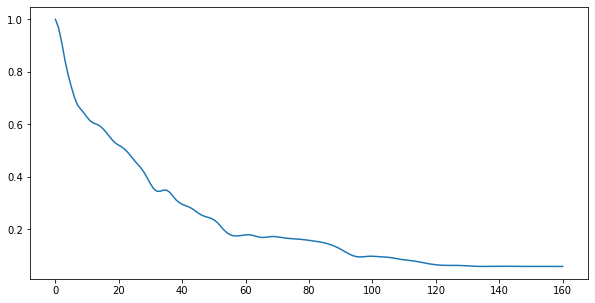

In [22]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 500
conv_tol = 1e-06

init_params = [np.random.rand(5)*2*np.pi, np.random.rand(3,4,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [23]:
node_params = params

In [24]:
def node_circ(optimized_params, wires):
    qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=wires)

In [25]:
@qml.qnode(dev5)
def node(optimized_params):
    node_circ(optimized_params, wires=range(5))
    return qml.state()

In [26]:
node(node_params)

tensor([-7.02203474e-02+0.j,  3.25268615e-03+0.j,  2.57806939e-03+0.j,
        -6.72171669e-02+0.j,  3.52770747e-03+0.j, -4.57592953e-01+0.j,
         3.20949456e-01+0.j,  2.89178758e-05+0.j,  6.11729946e-04+0.j,
         3.20993908e-01+0.j, -4.58251981e-01+0.j, -3.93410266e-03+0.j,
        -6.84650565e-02+0.j, -2.51215814e-03+0.j, -3.57686543e-03+0.j,
        -7.08835997e-02+0.j, -3.91177278e-02+0.j, -6.32907493e-04+0.j,
        -7.08222844e-03+0.j, -3.31751999e-01+0.j, -4.27432707e-03+0.j,
         1.83961297e-01+0.j,  1.81067091e-01+0.j,  4.70130560e-03+0.j,
        -5.23183207e-03+0.j,  1.80079660e-01+0.j,  1.82778129e-01+0.j,
         2.77513582e-03+0.j, -3.31149872e-01+0.j,  7.16569744e-03+0.j,
         1.36761350e-03+0.j, -3.80778638e-02+0.j], requires_grad=True)

In [ ]:
# node_exact = 

In [ ]:
# np.dot(node(node_params), node_exact)

## Gluing two open nodes and four links into hexagram network

In [28]:
dev18 = qml.device('default.qubit', wires=18)

In [ ]:
@qml.qnode(dev18)
def cost_circ(initial_layer_weights, weights):
    node(node_params, wires=[0,1,2,3,4])
    node(node_params, wires=[5,6,7,8,9])
    
    # link([1,2])
    # link([3,4])
    # link([1,4])
    # link([2,3])
    
        
    
    # qml.adjoint(W)([0,1,2,3])

    # qml.SimplifiedTwoDesign(initial_layer_weights, weights, wires=[0,4,5,6,7])
        
    return qml.probs(wires=range(18))

In [ ]:
# def proj_probs(probs):
#     c = dict()
#     for i in range(len(probs)):
#         k=format(i,'08b')
#         if k[1:4]=='000':
#             c[k[0]+k[4:]] = probs[i]
#     return c['00000']/np.sum(list(c.values()))

In [ ]:
def cost_fn(initial_layer_weights, weights):
    return 1-proj_probs(cost_circ(initial_layer_weights, weights))

In [ ]:
initial_layer_weights=np.random.rand(6)*2*np.pi
weights=np.random.rand(1,5,2)*2*np.pi
cost_fn(initial_layer_weights, weights)

tensor(0.99954651, requires_grad=True)

Iteration = 0,  Cost = 0.99992244
Iteration = 20,  Cost = 0.52037750
Iteration = 40,  Cost = 0.29561435
Iteration = 60,  Cost = 0.17941566
Iteration = 80,  Cost = 0.15849507
Iteration = 100,  Cost = 0.09804664
Iteration = 120,  Cost = 0.06543366
Iteration = 140,  Cost = 0.05990671
Iteration = 160,  Cost = 0.05915126


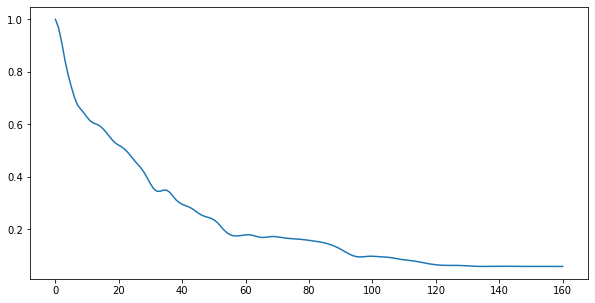

In [ ]:
opt = qml.AdamOptimizer(stepsize=0.1)

max_iterations = 500
conv_tol = 1e-06

init_params = [np.random.rand(6)*2*np.pi, np.random.rand(3,5,2)*2*np.pi]

params = init_params

cost = 0

costs=[]
paramses = []
paramses.append(params)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_fn, *params)
    conv = np.abs(cost - prev_cost)
    cost=prev_cost
    costs.append(cost)
    paramses.append(params)
    
    if n % 20 == 0:
        print('Iteration = {:},  Cost = {:.8f}'.format(n, cost))

    if conv <= conv_tol:
        break
    
plt.rcParams['figure.figsize'] = [10,5]

plt.plot(costs)

In [ ]:
hexagram_params = params

In [ ]:
def hexagram_circ(optimized_params, wires):
    qml.adjoint(qml.SimplifiedTwoDesign)(optimized_params[0], optimized_params[1],wires=wires)

In [29]:
dev6 = qml.device('default.qubit', wires=6)

In [ ]:
@qml.qnode(dev6)
def hexagram(optimized_params):
    node_circ(optimized_params, wires=range(6))
    return qml.state()

In [ ]:
hexagram(hexagram_params)

tensor([-7.02203474e-02+0.j,  3.25268615e-03+0.j,  2.57806939e-03+0.j,
        -6.72171669e-02+0.j,  3.52770747e-03+0.j, -4.57592953e-01+0.j,
         3.20949456e-01+0.j,  2.89178758e-05+0.j,  6.11729946e-04+0.j,
         3.20993908e-01+0.j, -4.58251981e-01+0.j, -3.93410266e-03+0.j,
        -6.84650565e-02+0.j, -2.51215814e-03+0.j, -3.57686543e-03+0.j,
        -7.08835997e-02+0.j, -3.91177278e-02+0.j, -6.32907493e-04+0.j,
        -7.08222844e-03+0.j, -3.31751999e-01+0.j, -4.27432707e-03+0.j,
         1.83961297e-01+0.j,  1.81067091e-01+0.j,  4.70130560e-03+0.j,
        -5.23183207e-03+0.j,  1.80079660e-01+0.j,  1.82778129e-01+0.j,
         2.77513582e-03+0.j, -3.31149872e-01+0.j,  7.16569744e-03+0.j,
         1.36761350e-03+0.j, -3.80778638e-02+0.j], requires_grad=True)

In [ ]:
# hexagram_exact = 

In [ ]:
# np.dot(hexagram(hexagram_params), hexagram_exact)